In [ ]:
import os
import glob
from IPython.display import Image as IPImage
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, Adamax
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.regularizers import l2
from keras.applications import VGG16, DenseNet121
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Configuration Kaggle With and Goggle Colab

In [ ]:
!pip install kaggle
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir ~/.kaggle

In [ ]:
cp -r /content/drive/MyDrive/APIKey/* ~/.kaggle/


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

# **Ultrasound Image Data**

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset

 98% 191M/195M [00:05<00:00, 44.0MB/s]
100% 195M/195M [00:05<00:00, 38.2MB/s]


In [ ]:
!unzip breast-ultrasound-images-dataset.zip

Archive:  breast-ultrasound-images-dataset.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflating: Data

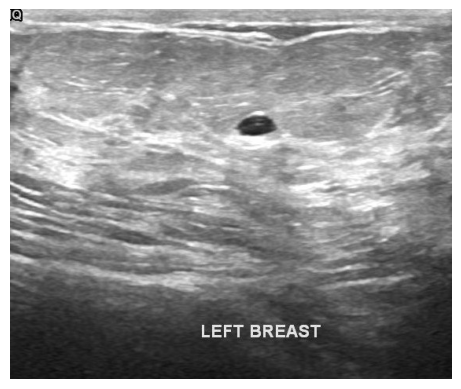

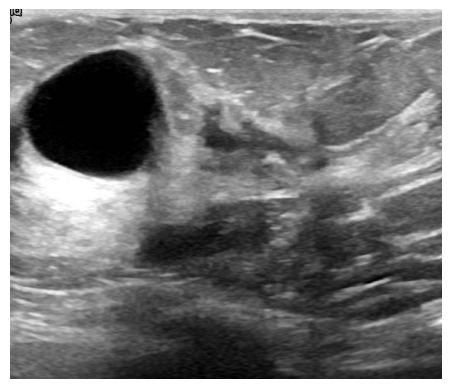

In [ ]:
import matplotlib.image as mpimg

image_path_1 = "/content/Dataset_BUSI_with_GT/benign/benign (1).png"
image_1 = mpimg.imread(image_path_1)
plt.imshow(image_1)
plt.axis('off')
plt.show()

image_path_2 = "/content/Dataset_BUSI_with_GT/benign/benign (10).png"
image_2 = mpimg.imread(image_path_2)
plt.imshow(image_2)
plt.axis('off')
plt.show()


In [ ]:
train_data = '/content/Dataset_BUSI_with_GT'
train_files = [i for i in glob.glob(train_data + "/*/*")]
np.random.shuffle(train_files)
labels = [os.path.dirname(i).split("/")[-1] for i in train_files]
data = zip(train_files, labels)
training_data = pd.DataFrame(data, columns=["Path", "Label"])


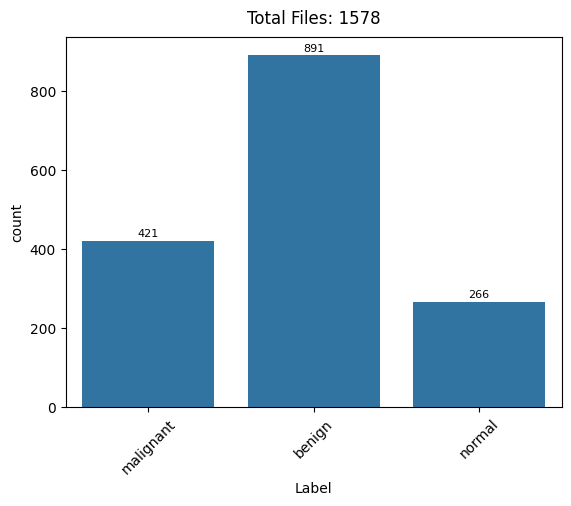

In [ ]:
ax = sns.countplot(x=training_data["Label"])
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)
plt.xticks(rotation=45)
plt.title(f'Total Files: {len(training_data)}', pad=10)
plt.show()


In [ ]:
# Set parameters
batch_size = 16
image_size = (256, 256)
num_channels = 3
epochs = 10
checkpoint_path = "/content/drive/MyDrive/Dataset"

In [ ]:
# Define preprocess_image function
def preprocess_image(img):
    return img

In [ ]:
# Load and preprocess data
train_data = '/content/Dataset_BUSI_with_GT'
data_paths = []
labels = []

In [ ]:
main_dirs = os.listdir(train_data)
for folder_name in main_dirs:
    folder_path = os.path.join(train_data, folder_name)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data_paths.append(file_path)
        labels.append(folder_name)

In [ ]:
# Split data into train, validation, and test sets
train_data, test_data = train_test_split(pd.DataFrame({'Path': data_paths, 'Label': labels}), test_size=0.2, random_state=123)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=123)

In [ ]:
# ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(preprocessing_function=preprocess_image,
    rescale=1.0/255)

In [ ]:
# Convert label columns to string
train_data['Label'] = train_data['Label'].astype(str)
val_data['Label'] = val_data['Label'].astype(str)
test_data['Label'] = test_data['Label'].astype(str)

In [ ]:
# Create data generators
train_generator = datagen.flow_from_dataframe(
    train_data,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)


Found 1262 validated image filenames belonging to 3 classes.


In [ ]:
valid_generator = datagen.flow_from_dataframe(
    val_data,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 158 validated image filenames belonging to 3 classes.


In [ ]:
test_generator = datagen.flow_from_dataframe(
    test_data,
    x_col='Path',
    y_col='Label',
    target_size=image_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

In [ ]:
# Load pre-trained DenseNet121 model
base_model = DenseNet121(weights='/content/drive/MyDrive/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(256, 256, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Build the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Model summary
model.summary()

In [ ]:
# Model checkpoint
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[checkpoint]
)

In [ ]:
# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
test_accuracy_percentage = test_accuracy * 100

In [ ]:
# Print test results
test_results = pd.DataFrame({
    'Set': ['Test'],
    'Loss': [test_loss],
    'Accuracy': [f'{test_accuracy_percentage:.2f}%']
})
print(test_results)

# **Histopathology Images**

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images
!unzip breast-histopathology-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflating: IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2301_class0.png  
  inflating: IDC_regular_

In [ ]:
import glob
import random

# Load image paths
breast_img = glob.glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive=True)

# Separate images into cancer and non-cancer categories
non_can_img = []
can_img = []

for img in breast_img:
    if img[-5] == '0':
        non_can_img.append(img)
    elif img[-5] == '1':
        can_img.append(img)

In [ ]:
# Randomly sample the images
some_non_img = random.sample(non_can_img, len(non_can_img))
some_can_img = random.sample(can_img, len(can_img))

In [ ]:
import cv2
import numpy as np

# Resize images and store them with labels
resize_width = 50
resize_height = 50

non_img_arr = [(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (resize_width, resize_height), interpolation=cv2.INTER_LINEAR), 0) for img in some_non_img]
can_img_arr = [(cv2.resize(cv2.imread(img, cv2.IMREAD_COLOR), (resize_width, resize_height), interpolation=cv2.INTER_LINEAR), 1) for img in some_can_img]

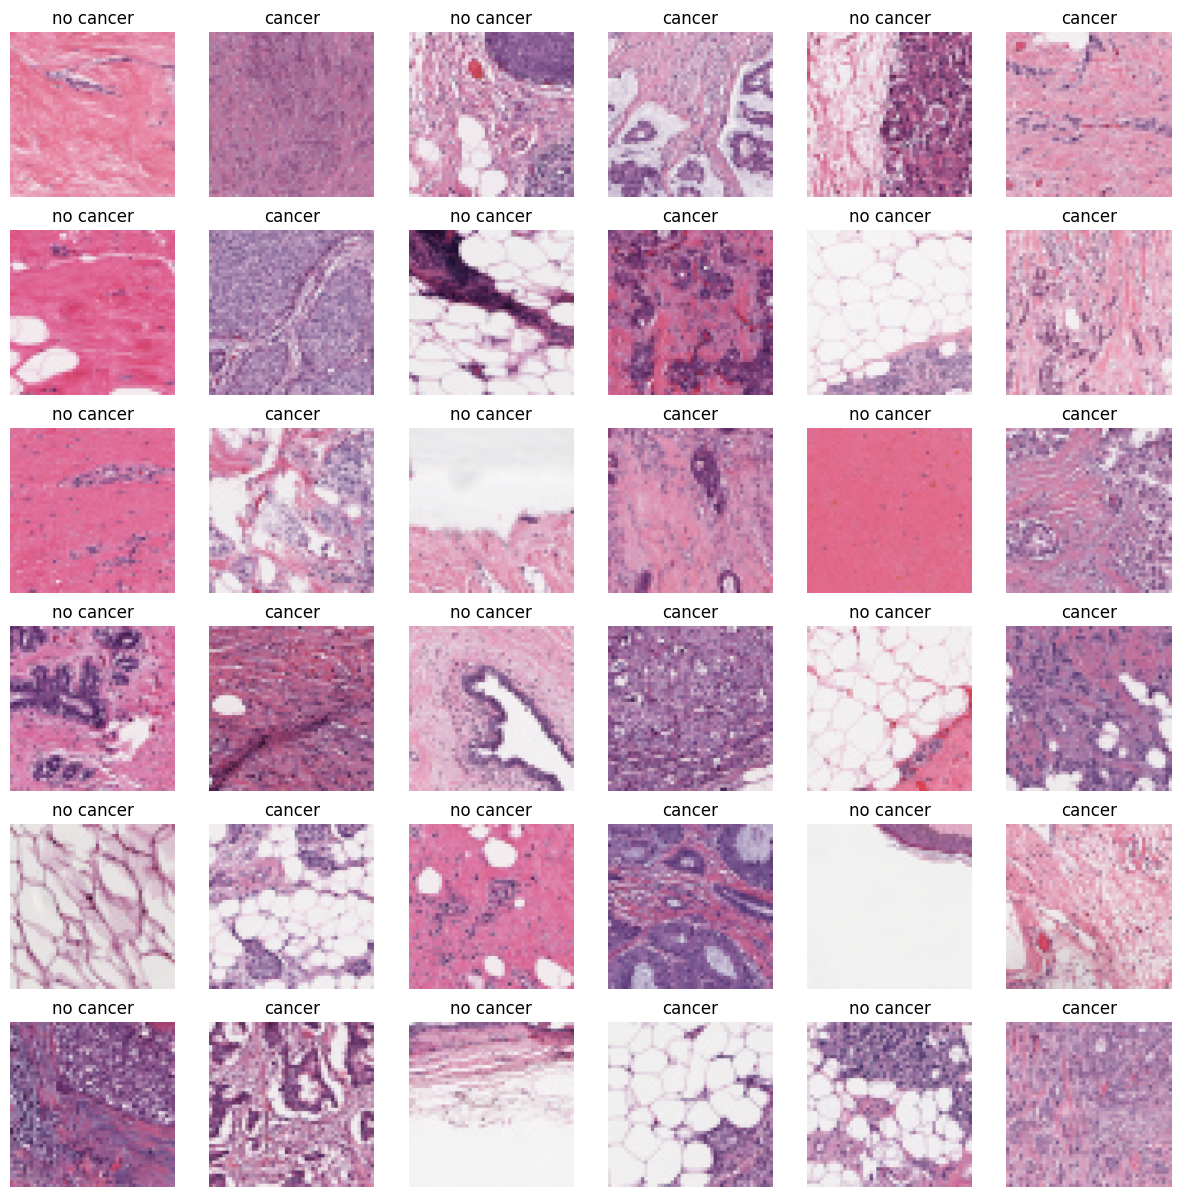

In [ ]:
from keras.preprocessing import image

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(non_can_img), 18)
some_can = np.random.randint(0, len(can_img), 18)

s = 0
for num in some_non:

        img = image.load_img((non_can_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

s = 1
for num in some_can:

        img = image.load_img((can_img[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

In [ ]:
# Stack the image arrays and labels
X = np.array([arr[0] for arr in non_img_arr + can_img_arr])
y = np.array([arr[1] for arr in non_img_arr + can_img_arr])

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

print('X shape:', X.shape)

X shape: (277524, 50, 50, 3)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

# Define input shape
input_shape = X_train[0].shape

# Load DenseNet121 pre-trained on ImageNet without the top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Combine base model with custom top layers
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


29084464/29084464 [==============================] - 1s 0us/step
Epoch 1/10
6245/6245 [==============================] - 500s 71ms/step - loss: 0.3302 - accuracy: 0.8611 - val_loss: 0.4758 - val_accuracy: 0.8182
Epoch 2/10
6245/6245 [==============================] - 436s 70ms/step - loss: 0.3036 - accuracy: 0.8722 - val_loss: 0.7943 - val_accuracy: 0.7331
Epoch 3/10
6245/6245 [==============================] - 436s 70ms/step - loss: 0.2871 - accuracy: 0.8794 - val_loss: 0.4922 - val_accuracy: 0.7308
Epoch 4/10
6245/6245 [==============================] - 435s 70ms/step - loss: 0.2753 - accuracy: 0.8850 - val_loss: 0.4037 - val_accuracy: 0.8072
Epoch 5/10
6245/6245 [==============================] - 435s 70ms/step - loss: 0.2664 - accuracy: 0.8885 - val_loss: 0.4276 - val_accuracy: 0.8241
Epoch 6/10
6245/6245 [==============================] - 441s 71ms/step - loss: 0.2599 - accuracy: 0.8905 - val_loss: 0.7309 - val_accuracy: 0.7847
Epoch 7/10
6245/6245 [==============================]

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

1735/1735 [==============================] - 20s 11ms/step - loss: 0.4239 - accuracy: 0.8210
Test accuracy: 0.8209710717201233


# **Wisconsin Dataset**

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/breast_cancer 1 .csv')

In [ ]:
X = dataset.iloc[ : ,3: ]
Y = dataset.iloc[ : ,2]

In [ ]:
#converting all features to the same scale
from sklearn.preprocessing import MinMaxScaler
mmScaler = MinMaxScaler()
X = mmScaler.fit_transform(X.astype(float))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd

# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Support Vector Machine": svm.SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K Nearest Neighbors": KNeighborsClassifier()
}

# Results storage
results = {}

# Iterate over classifiers
for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    # Calculate metrics
    report = classification_report(y_test, pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    # Store results
    results[clf_name] = {
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1-score": report["macro avg"]["f1-score"],
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Display results

results_df

,precision,recall,f1-score,accuracy,confusion_matrix
Logistic Regression,0.971831,0.957447,0.963285,0.964912,"[[67, 0], [4, 43]]"
Gaussian Naive Bayes,0.899621,0.902032,0.900752,0.903509,"[[61, 6], [5, 42]]"
Support Vector Machine,0.974425,0.971261,0.97276,0.973684,"[[66, 1], [2, 45]]"
Decision Tree,0.898883,0.908384,0.901809,0.903509,"[[59, 8], [3, 44]]"
Random Forest,0.963798,0.963798,0.963798,0.964912,"[[65, 2], [2, 45]]"
K Nearest Neighbors,0.971831,0.957447,0.963285,0.964912,"[[67, 0], [4, 43]]"


Epoch 1/300
15/15 [==============================] - 1s 3ms/step - loss: 0.6856 - accuracy: 0.5780
Epoch 2/300
15/15 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.7538
Epoch 3/300
15/15 [==============================] - 0s 3ms/step - loss: 0.6003 - accuracy: 0.8593
Epoch 4/300
15/15 [==============================] - 0s 3ms/step - loss: 0.5128 - accuracy: 0.8703
Epoch 5/300
15/15 [==============================] - 0s 3ms/step - loss: 0.4020 - accuracy: 0.8835
Epoch 6/300
15/15 [==============================] - 0s 3ms/step - loss: 0.3036 - accuracy: 0.9143
Epoch 7/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2438 - accuracy: 0.9231
Epoch 8/300
15/15 [==============================] - 0s 3ms/step - loss: 0.2006 - accuracy: 0.9275
Epoch 9/300
15/15 [==============================] - 0s 3ms/step - loss: 0.1686 - accuracy: 0.9473
Epoch 10/300
15/15 [==============================] - 0s 3ms/step - loss: 0.1454 - accuracy: 0.9516
Epoch 11/

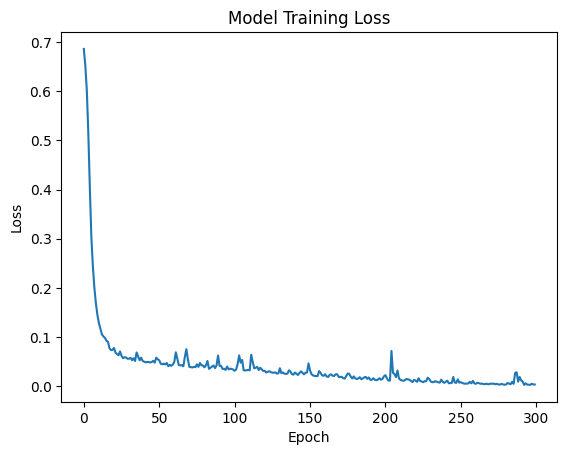

Model Accuracy: 100.00%
Classification Report:
  Class  Precision  Recall  F1-Score  Support
0     0       0.98    0.97      0.98       67
1     1       0.96    0.98      0.97       47

Confusion Matrix:
[[65  2]
 [ 1 46]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.nn import softmax
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the model
model = Sequential([
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(30, activation='relu'),
    Dense(2, activation=softmax) #predictions
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and capture the training history
history = model.fit(x=X_train, y=y_train.values, epochs=300)

# Generate predictions
predictions = model.predict(X_test)
predictedList = [np.argmax(prediction) for prediction in predictions]

# Convert predictions to DataFrame
predictionsPandas = pd.DataFrame(predictedList)

# Calculate classification report and confusion matrix
classification_rep = classification_report(y_test, predictionsPandas)
conf_matrix = confusion_matrix(y_test, predictionsPandas)

# Parse classification report
report_data = []
lines = classification_rep.split('\n')
for line in lines[2:-5]:  # Skip header and footer lines
    row_data = line.split()
    class_name = row_data[0]
    precision = float(row_data[1])
    recall = float(row_data[2])
    f1_score = float(row_data[3])
    support = int(row_data[4])
    report_data.append([class_name, precision, recall, f1_score, support])

# Convert classification report data to DataFrame
classification_rep_df = pd.DataFrame(report_data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])

# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Model accuracy
accuracy = history.history['accuracy'][-1]
print("Model Accuracy: {:.2f}%".format(accuracy * 100))

# Display results
print("Classification Report:")
print(classification_rep_df)
print("\nConfusion Matrix:")
print(conf_matrix)